# <center> Analysis of Electricity Production and CO2 Emmissions </center>
### <center> Attempt to corrolate production, GDP growth and CO2 changes </center>

## 1. Objective
### 1.1 Introduction
This report was inspired by the increasing attention placed on the emerging climate crisis. This report will attempt an analysis of factors that influence changes in CO2 emissions within the broader context of climate change concerns. I want to explore the correlation between CO2 emissions and key socioeconomic indicators, including electricity production, population growth, and GDP growth. By delving into these relationships, I hope to uncover underlying trends that have contributed to the surge in CO2 emissions over the last 30 years.
### 1.2 Purpose
At its core, this analysis seeks to achieve a twofold purpose. Firstly, it aims to identify patterns and correlations that shed light on the factors influencing the rise in CO2 emissions. Secondly, it examines the potential association between higher GDP per capita and the adoption of environmentally friendly generation techniques that can lead to reductions in CO2 emissions. This dual focus offers insights into how economic growth and sustainable practices might intersect.
### 1.3 Variables Considered
1. **CO2 Emissions:** The quantification of carbon dioxide emissions remains pivotal in addressing climate change concerns and shaping environmental policies.
1. **Electricity Production:** The measurement of total electricity generation provides insights into energy consumption trends and their environmental implications.
1. **Population Growth:** Analysing population growth rates offers context for understanding the scale of emissions and consumption patterns.
1. **GDP Growth:** Assessing economic growth through Gross Domestic Product changes unveils potential links between prosperity and sustainable practices.

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from functions import transpose_data, remove_years_before, convert_columns_to_float, create_line_graph

## 2. Data Collection and Methodology

### 2.1 Data Sources
I started by searching for data on Kaggle, which led me to the World Bank DataBank [https://databank.worldbank.org/data/home.aspx](https://databank.worldbank.org/data/home.aspx), and the Energy Institute [https://www.energyinst.org/statistical-review/resources-and-data-downloads](https://www.energyinst.org/statistical-review/resources-and-data-downloads).

1. **World Bank DataBank:** This dataset offers a comprehensive collection of socioeconomic indicators, including population growth, GDP growth, and CO2 emissions. The World Bank DataBank provides reliable and standardised data, enhancing the reliability of our analysis.
1. **Energy Institute Dataset:** This dataset contains information related to electricity production, including the types of energy sources used for generation. The Energy Institute dataset enriches our analysis by offering insights into the composition of electricity generation.

### 2.2 Data Collection & Ethical Considerations
The data was obtained from the respective sources, using the maximum available time period and data sources. The data could then be filtered to the greatest overlap between sources, where data was available for all the required key metrics. The data was sourced from public datasets, that at most require attribution.

### 2.3 Limitations of Data
While the datasets used in this analysis provide valuable insights into the correlation between CO2 emissions, electricity production, population growth, and GDP growth, it's important to recognise their limitations.

#### 2.3.1. Limited Overlap
The reliable overlap in the datasets was found to begin from the year 1990 onwards. This temporal constraint might impact the comprehensiveness of our analysis, as earlier trends and patterns could be missed.

#### 2.3.2 Missing Data in Energy Composition
In the energy dataset sourced from the Energy Institute, it was observed that not all countries provided reliable and complete energy composition data. This missing information could introduce bias or reduce the accuracy of our analysis, particularly when examining the relationship between CO2 emissions and specific energy sources.

#### 2.3.3 Data Discrepancies
Despite efforts to standardise metrics and units, potential discrepancies in data reporting methodologies between different countries and sources could introduce inconsistencies that might affect the precision of our findings.

### 2.4 Data Preparation
Prior to analysis, the collected data underwent preprocessing steps to ensure uniformity and accuracy. This involved addressing missing values, standardising units, and aligning timeframes. In instances where data from the different sources required merging, appropriate techniques were employed to maintain data integrity.

#### 2.4.1 Aligning Dataset Structure and Filtering Invalid Years
To ensure consistency across the datasets, I addressed a structural discrepancy between the World Bank datasets and the Energy Institute dataset. The World Bank datasets presented years as columns, whereas the Energy Institute dataset provided data for each year in rows. To harmonise these formats, I wrote a function to transpose these datasets. This transformation involved leveraging the 'melt' function from the pandas library, which reconfigured the arrangement, placing years within rows rather than columns.

Upon scrutinising the data, it was evident that certain years lacked complete information across all datasets, specifically preceding 1990. Therefore, I decided to focus on data from 1990 onwards, effectively omitting any records predating this year.

In [11]:
start_year = 1990

# Import Electricity Data
value_columns = [
    "solar_twh",
    "wind_twh",
    "hydro_twh",
    "nuclear_twh",
    "biogeo_twh",
    "electbyfuel_gas",
    "electbyfuel_coal",
    "electbyfuel_oil",
    "electbyfuel_other",
]
electricity = pd.read_csv("input/electricity_panel_format.csv")
electricity = electricity[
    ["Country", "Year", "ISO3166_alpha3"]
    + value_columns
    + [
        "elect_twh",
    ]
]
filtered_elect = remove_years_before(electricity, start_year)
convert_columns_to_float(filtered_elect, value_columns + ["elect_twh"])
filtered_elect = filtered_elect.rename(
    columns={"ISO3166_alpha3": "Country Code", "Country": "Country Name"}
)
# Replace some country name discrepancies in the Electricity Data
filtered_elect.loc[:, "Country Name"] = (
    filtered_elect["Country Name"]
    .replace("US", "United States")
    .replace("Egypt", "Egypt, Arab Rep.")
    .replace("Iran", "Iran, Islamic Rep.")
)

# Import CO2 Data and skip first 4 rows
co2 = transpose_data(
    "input/API_EN.ATM.CO2E.KT_DS2_en_csv_v2_5728932.csv",
    4,
    ["Country Name", "Country Code"],
    2,
    "Year",
    "CO2 Emissions (kt)",
    ["Indicator Name", "Indicator Code"],
)
filtered_co2 = remove_years_before(co2, start_year)

# Import GDP Data and skip first 4 rows
gdp = transpose_data(
    "input/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_5728855.csv",
    4,
    ["Country Name", "Country Code"],
    2,
    "Year",
    "GDP (current US$)",
    ["Indicator Name", "Indicator Code"],
)
filtered_gdp = remove_years_before(gdp, start_year)

# Import Population Data and skip first 4 rows
population = transpose_data(
    "input/API_SP.POP.TOTL_DS2_en_csv_v2_5695140.csv",
    4,
    ["Country Name", "Country Code"],
    2,
    "Year",
    "Population",
    ["Indicator Name", "Indicator Code"],
)
filtered_pop = remove_years_before(population, start_year)

### 2.4.2 Filtering Out Invalid Data
Subsequently, I eliminated invalid data entries. This involved the exclusion of specific rows featuring a GDP value of zero, or a population of zero, or zero emission data, or those lacking electricity production data. Additionally, data points were removed where the cumulative sum of electricity sources fails to correspond to the total electricity production, accounting for potential floating-point imprecisions. This rigorous culling process guarantees the integrity and reliability of our dataset.

In [12]:
# We must also filter out data that is incomplete or not useful
# Remove any rows where the total electricity produced is 0
filtered_elect = filtered_elect[filtered_elect["elect_twh"] != 0]

# Also, remove any rows where the total electricity does not match the sum of the other columns
# We use a rounding function to account for any floating point errors
filtered_elect = filtered_elect[
    round(filtered_elect["elect_twh"], 4)
    == round(filtered_elect[value_columns].sum(axis=1), 4)
]

# Remove any rows where the CO2 emissions are 0
filtered_co2 = filtered_co2[filtered_co2["CO2 Emissions (kt)"] != 0]

# Remove any rows where the GDP is 0
filtered_gdp = filtered_gdp[filtered_gdp["GDP (current US$)"] != 0]

# Remove any rows where the population is 0
filtered_pop = filtered_pop[filtered_pop["Population"] != 0]

In [13]:
# Output final input datasets for verification
filtered_elect.to_csv("output/electricity_filtered.csv")
filtered_co2.to_csv("output/co2_filtered.csv")
filtered_gdp.to_csv("output/gdp_filtered.csv")
filtered_pop.to_csv("output/population_filtered.csv")

### 2.4.3 Consolidated Dataset
The final step in the data preparation journey involved the amalgamation of the distinct datasets into a unified and cohesive structure. This ensured that we retain only data with matching year, country, and data points across all datasets. Using consequetive merge operations, I generated a consolidated dataset characterised by its harmonious composition. The final dataset provides a meaninful dataset that can be used for further analysis. Hopefully I'll be able to derive meaningful insights from this singular, concise dataset.

In [14]:
# Merge the electricity and CO2 dataset using the Country Code and Year columns
final_dataset = filtered_elect.merge(
    filtered_co2, on=["Country Name", "Country Code", "Year"], how="inner"
)

# Merge the merged dataset and the GDP dataset using the Country Code and Year columns
final_dataset = final_dataset.merge(
    filtered_gdp, on=["Country Name", "Country Code", "Year"], how="inner"
)

# Merge the merged dataset and the population dataset using the Country Code and Year columns
final_dataset = final_dataset.merge(
    filtered_pop, on=["Country Name", "Country Code", "Year"], how="inner"
)

# Save the merged dataset to a CSV file
final_dataset.to_csv("output/final_dataset.csv")

# describe the merged dataset
final_dataset.describe()

# Get a list of unique countries
unique_countries = final_dataset['Country Name'].unique()

## 3. Exploratory Data Analysis
### 3.1 Number of Countries for Analysis
Before delving into the comprehensive visualisations and exploratory data analysis, it's essential to highlight the robustness of the dataset. Through the process of data cleaning and the removal of invalid subsets, I arrived at a curated set of datasets that hold substantial and reliable data for all the metrics under scrutiny. This refined dataset will enable me to conduct a meaningful analysis of the relationships between electricity generation, GDP growth, and CO2 emissions per capita.

In [15]:
# Count the number of distinct countries
num_distinct_countries = len(unique_countries)
print("Number of unique countries:", num_distinct_countries)

# Earliest year in the dataset
min_year = final_dataset["Year"].min()
print("Earliest year in the dataset:", min_year)

# Latest year in the dataset
max_year = final_dataset["Year"].max()
print("Latest year in the dataset:", max_year)

Number of unique countries: 29
Earliest year in the dataset: 1990
Latest year in the dataset: 2020


### 3.2 Analyzing the Relationship between Electricity Generation, GDP Growth, and CO2 Emissions per Capita
In trying to understand the relationship between electricity generation, GDP growth, and CO2 emissions per capita, I perform the below data exploration and visualisation activities. This involved preparing and manipulating the data, and using visualisation techniques to discover meaningful insights.

#### 3.2.1 Data Preparation and Enrichment
I pre-calculated metrics such as CO2 emissions and GDP per capita, for the subsequent analysis. Furthermore, I also calculated electricity production per capita from the Energy Institute's dataset, to further enrich the dataset.

#### 3.2.2 Crafting Informative Visualisations
I first attempted to graph the data using scatter plots, but they were not very meaningful, and so I settled on using a series of line plots. Each plot showcases two key factors (electricity generation and GDP growth) against CO2 emissions per capita, for each country in the dataset. From these line graphs, I am able to dive deep into country-specific dynamics.

#### 3.2.3 Multifaceted Understanding
These visualisations allowed me to uncover trends and relationships between electricity production, GDP growth and CO2 emissions. By juxtaposing CO2 emissions per capita with electricity generation and GDP growth, I gained a multidimensional perspective on how these factors intertwine. The dual y-axes elegantly displayed the corresponding values for each category, enabling me to visualise fluctuations and correlations over the years.

#### 3.2.4 Dealing with Asymmetry
Recognising the possibility of an uneven number of countries represented in the dataset, I ensured that the last subplot in the grid was not left empty when dealing with an odd number of records. This further underpins the desire to present data accurately and comprehensively.

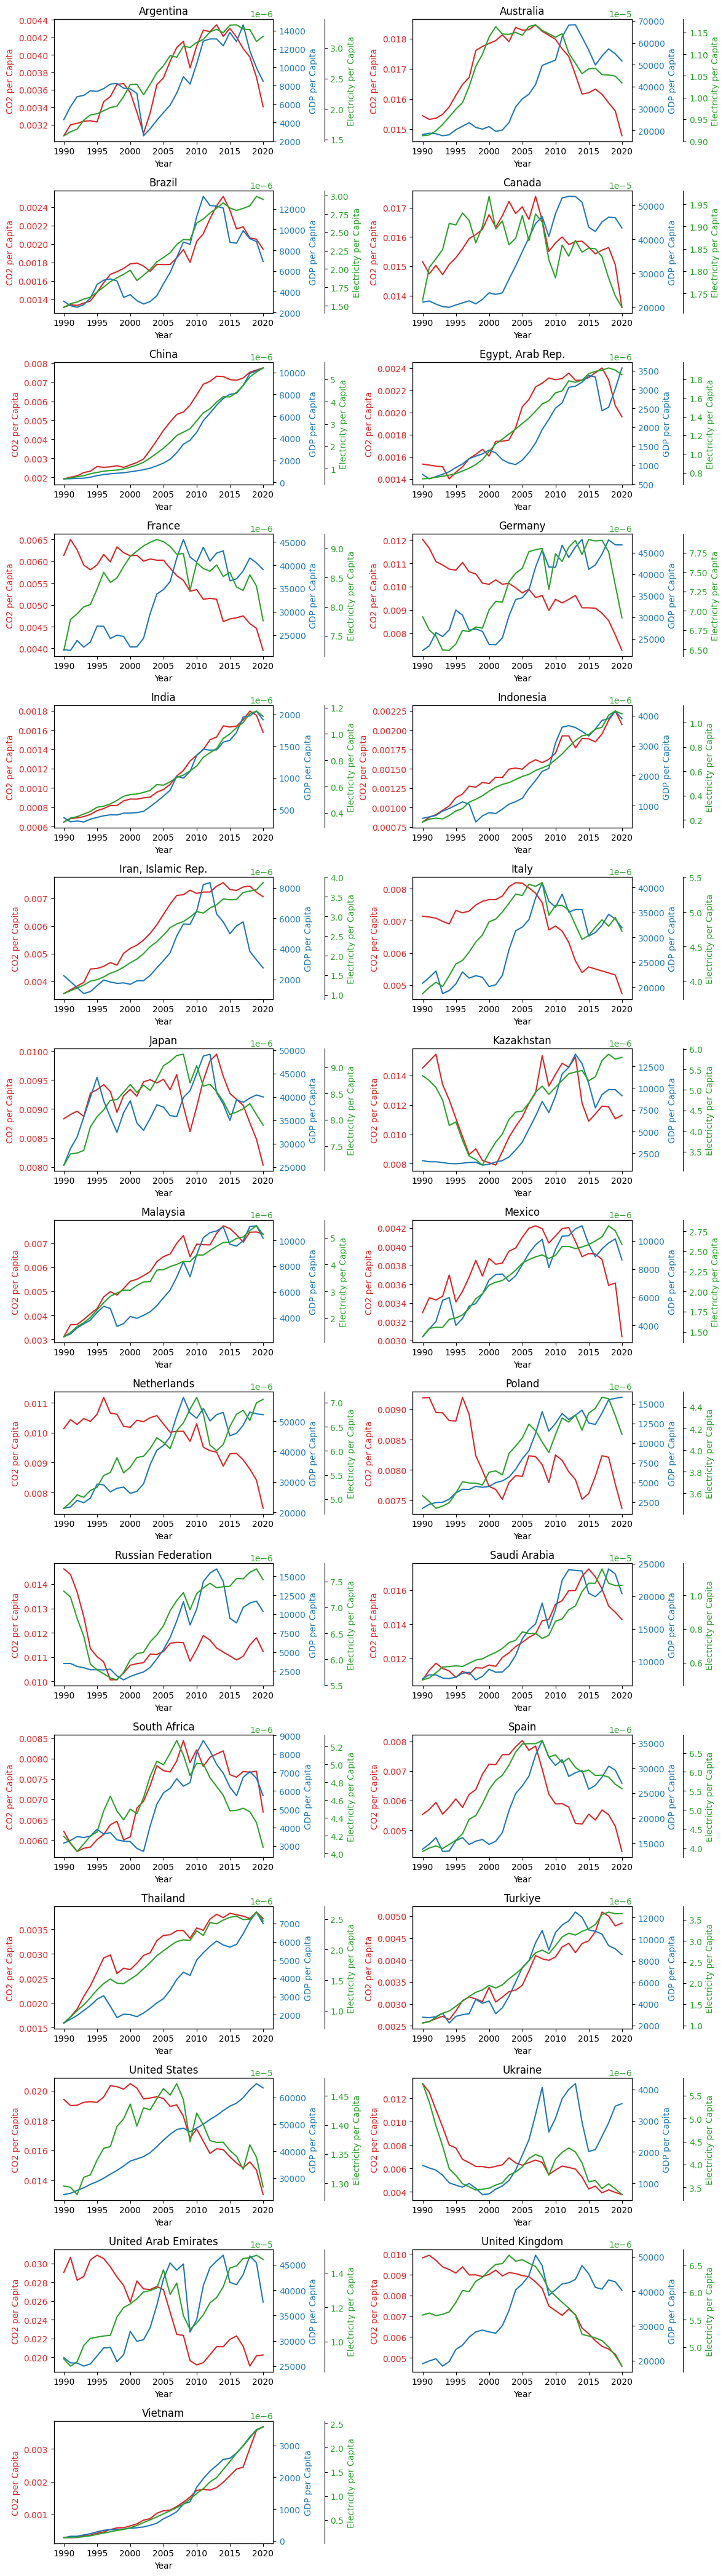

In [16]:
# Calculate GDP per capita, CO2 emissions per capita, and total electricity production per capita
final_dataset["GDP per Capita"] = (
    final_dataset["GDP (current US$)"] / final_dataset["Population"]
)
final_dataset["CO2 per Capita"] = (
    final_dataset["CO2 Emissions (kt)"] / final_dataset["Population"]
)
final_dataset["Electricity per Capita"] = (
    final_dataset["elect_twh"] / final_dataset["Population"]
)

# Calculate the number of rows and columns needed for subplots
num_rows = len(unique_countries) // 2 + len(unique_countries) % 2
num_cols = 2

# Create subplots with two plots per row, and adjust figsize for taller plots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 42))

# Loop through each country and create a separate plot
for idx, country in enumerate(unique_countries):
    row = idx // num_cols
    col = idx % num_cols

    country_data = final_dataset[final_dataset["Country Name"] == country]
    years = country_data["Year"]
    co2_per_capita = country_data["CO2 per Capita"]
    gdp_per_capita = country_data["GDP per Capita"]
    electricity_per_capita = country_data["Electricity per Capita"]

    ax = axs[row, col]

    color = "tab:red"
    ax.set_xlabel("Year")
    ax.set_ylabel("CO2 per Capita", color=color)
    ax.plot(years, co2_per_capita, color=color)
    ax.tick_params(axis="y", labelcolor=color)

    ax2 = ax.twinx()
    color = "tab:blue"
    ax2.set_ylabel("GDP per Capita", color=color)
    ax2.plot(years, gdp_per_capita, color=color)
    ax2.tick_params(axis="y", labelcolor=color)

    ax3 = ax.twinx()
    ax3.spines["right"].set_position(("outward", 60))
    color = "tab:green"
    ax3.set_ylabel("Electricity per Capita", color=color)
    ax3.plot(years, electricity_per_capita, color=color)
    ax3.tick_params(axis="y", labelcolor=color)

    ax.set_title(country)

# If there's an odd number of countries, remove the last subplot
if len(unique_countries) % 2 == 1:
    fig.delaxes(axs[num_rows - 1, num_cols - 1])

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

### 3.3 Comments on the Initial Data Exploration

By examining the above visualisations, some intriguing trends can be seen. Of immediate interest is that in almost all cases there is a clear correlation between the increase of electricity production, CO2 emissions, and GDP.

I've highlighted a few countries that have interesting trendlines to either illustrate this point, or that stand in juxtaposition to the prevailing trend.

#### 3.4.1 China
China's data provides a good illustration of the normally linear relationship between electricity production, GDP growth, and CO2 emissions. Due to China's vast size and economic import on the world stage, their data bears further scrutiny.

#### 3.4.2 Germany
Germany's data shows a reasonably stable GDP, coupled with lower emissions and electricity production. It would be interesting to explore Germany's approach further to determine whether they offer a model for sustainable growth.

#### 3.4.3 South Africa
South Africa is of direct interest to me, being South African myself. The data clearly shows the impact of the ongoing electricity crisis, and the rotational power cuts, colloquially referred to as loadshedding. This national energy crisis is clearly reflected in the economic indicators, showing the stark reality that energy security plays in sustained economic growth and prosperity.

#### 3.4.4 Mexico
Mexico's data shows a significant decline in CO2 emissions, which would be interesting to explore further. While electricity and GDP has experienced a less dramatic downturn, there was a substantial decrease in CO2 per capita. I'm curious to see whether there are any other indicators that can be seen from the energy production data.

#### 3.4.5 Netherlands
The Netherlands has shown a steady decline in CO2 emissions per capita, juxtaposed with relatively unaffected GDP and electricity production. This would seem to indicate their commitment to sustainable energy production.

#### 3.4.6 Russian Federation
The Russian Federation's data highlights their historical milestones. A sharp decline in CO2 and electricity production in the early 1990s seems to alin with the fall of communism and the subsequent shift towards recapitalization and privatization. Their stable CO2 emissions per capita amidst increasing electricity and GDP numbers offer a window into the nation's economic and political metamorphosis.

#### 3.4.7 USA
The United States, a global economic powerhouse, provides a noteworthy study. While GDP per capita shows a steady upward trajectory, CO2 emissions and electricity production have shown a steady decline, which certainly indicates that the USA is progressing well on the path to sustainable growth and emissions reduction.

#### 3.4.8 UAE
The United Arab Emirates' data seems to indicate a commitment to emissions reduction. As CO2 emissions per capita decline consistently, GDP and electricity production continue to rise. This seemingly intentional trajectory bears further investigation, but does point to their desire to achieve sustainable development.

By looking more closely at these outlier countries, I hope to spot some further trends in their electricity mix, or other indicators. Having seen the data thus far, it also would prompt me to look for additional datasets that might shed further light on economic drivers and factors.

### 3.5 Investigate Energy Mix

By looking at the various energy sources in the highlighted coutries' energy mix, we may be able to identify trends or find additional correlations to our earlier assumptions based on the correlation between GDP, CO2 and electricity production. Our dataset provides us data for Coal, Nuclear, Solar, Wind, Geo, BioFuels, Oil, Gas, and other sources of electricity production. Below we will explore the energy mixes of the countries of interest.

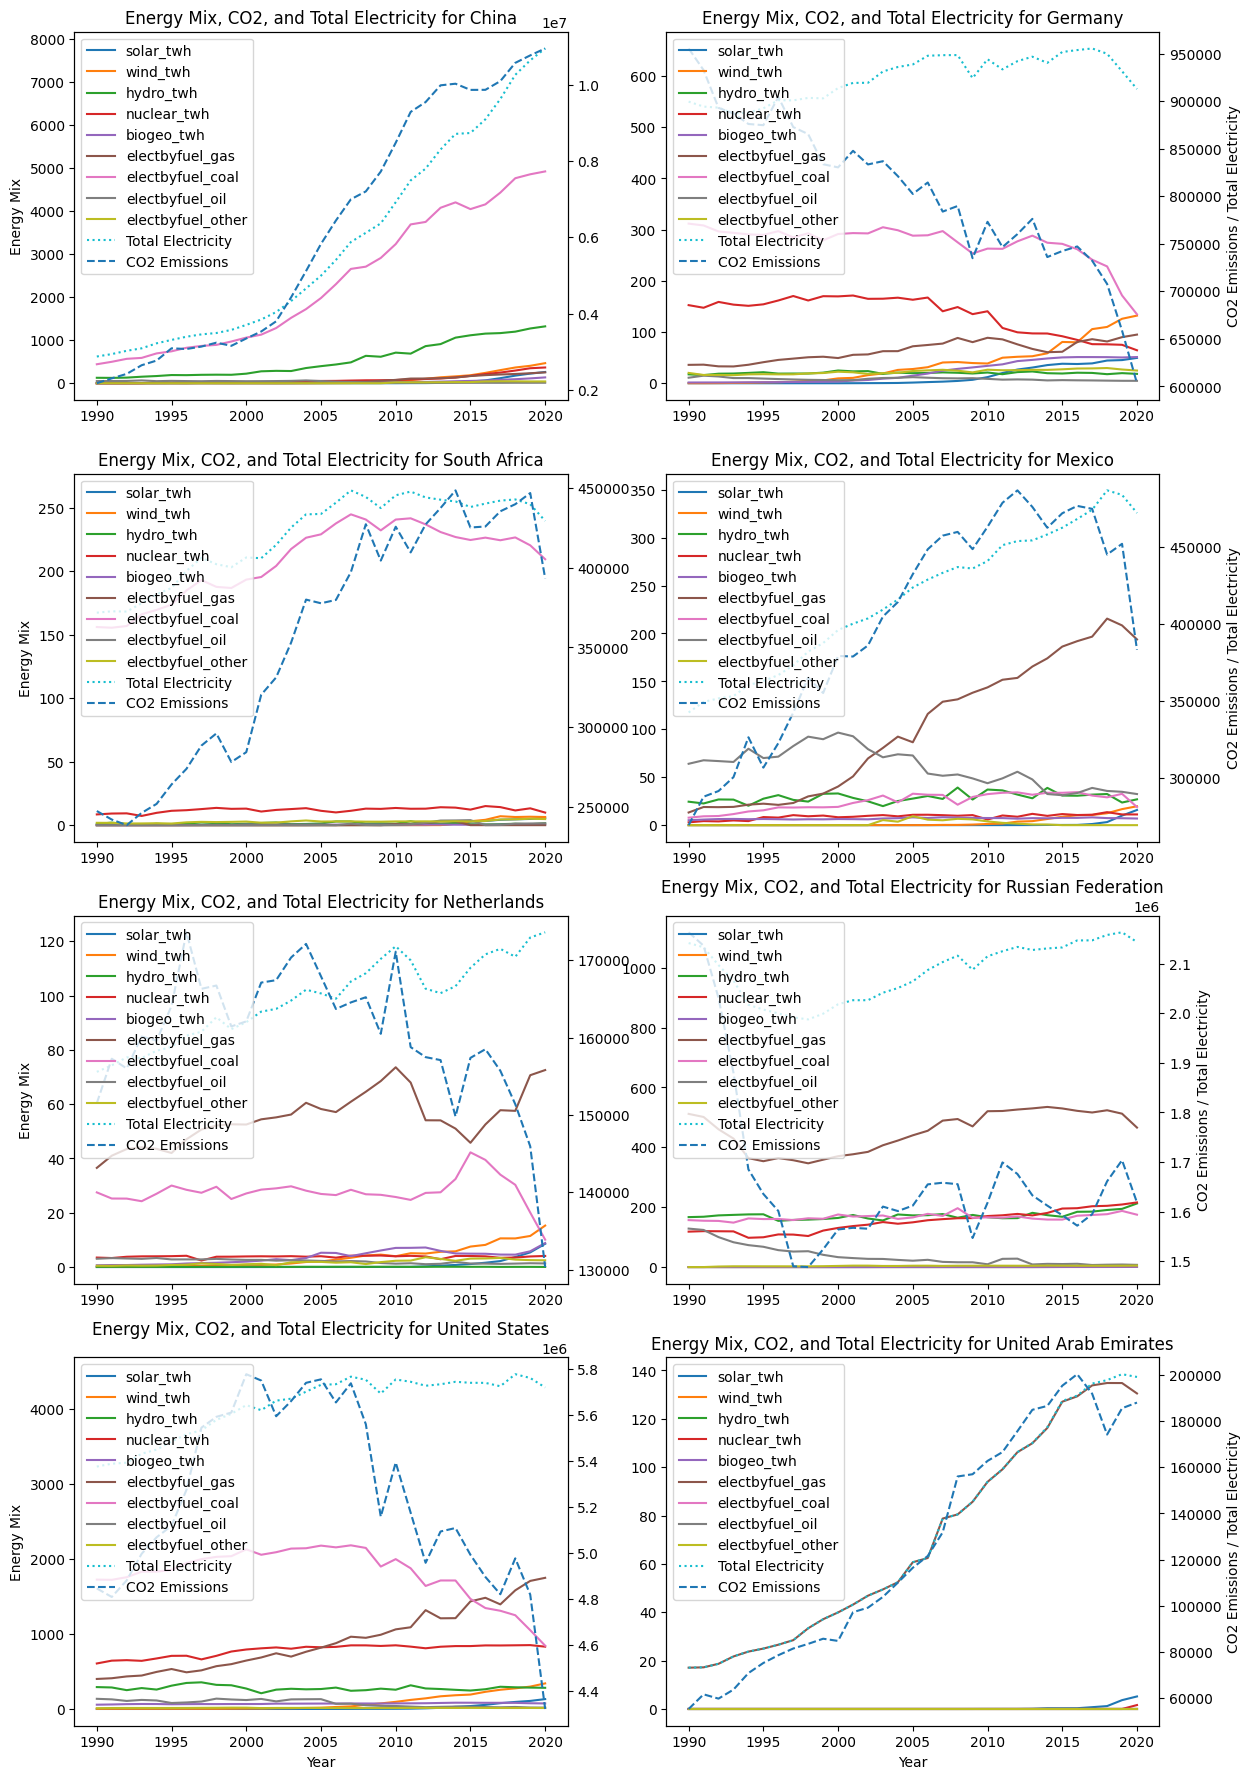

In [17]:
# List of countries you want to analyze
countries_of_interest = [
    "China",
    "Germany",
    "South Africa",
    "Mexico",
    "Netherlands",
    "Russian Federation",
    "United States",
    "United Arab Emirates",
]

# Calculate the number of rows and columns needed for subplots
num_rows = len(countries_of_interest) // 2 + len(countries_of_interest) % 2
num_cols = 2

fig, axs = plt.subplots(num_rows, num_cols, figsize=(14, 22))

# Loop through the selected countries
for idx, country in enumerate(countries_of_interest):
    row = idx // num_cols
    col = idx % num_cols
    country_data = final_dataset[final_dataset["Country Name"] == country]

    ax = axs[row, col]
    ax2 = ax.twinx()

    # Plot energy mix components
    for energy_type in value_columns:
        ax.plot(country_data["Year"], country_data[energy_type], label=energy_type)

    # Add CO2 emissions and total electricity production to the same plot
    ax.plot(
        country_data["Year"],
        country_data["elect_twh"],
        label="Total Electricity",
        linestyle="dotted",
    )
    ax2.plot(
        country_data["Year"],
        country_data["CO2 Emissions (kt)"],
        label="CO2 Emissions",
        linestyle="dashed",
    )

    # Set labels and titles
    if row == num_rows - 1:
        ax.set_xlabel("Year")
    if col % 2 == 0:
        ax.set_ylabel("Energy Mix")
    else:
        ax2.set_ylabel("CO2 Emissions / Total Electricity")
    plt.title(f"Energy Mix, CO2, and Total Electricity for {country}")

    # Combine legends from both axes
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc="upper left")

plt.show()

#### 3.5.1 Energy Mix Data
By reviewing the above energy mix graphs, it is evident that countries reducing the use of coal in their energy mix show the greatest reduction in CO2 emissions. An interesting case is the UAE, which generates almost all of its electricity from gas and which provides a linear correlation to their emissions. By contrast to this, the Netherlands has increased its use of gas, while decreasing their use of coal, which resulted in an overall reduction in their emissions. Mexico is also generating most of its electricity from gas, while having reduced their reliance on oil and coal, showing a reduction in emissions. China's reliance on coal is evidenced by their increasing emissions, however, the increase in the use of hydro power will hopefully offset future emissions.

South Africa's total production has plateued, and is still heavily reliant on coal. When looking at this graph in conjunction with the per capita values though, it's clear that the energy crisis is having a marked effect on the overall prosperity of individual South Africans.

### 3.6 Top Emissions and Electricity Producers
Lastly, I wanted to take a look at the top producers of eletricity and CO2 emissions, by raw numbers. This tells a very different story from the per capita graphs, as they provide a stark reminder of the gap between the wealthiest and poorest nations.

<Figure size 1200x1200 with 0 Axes>

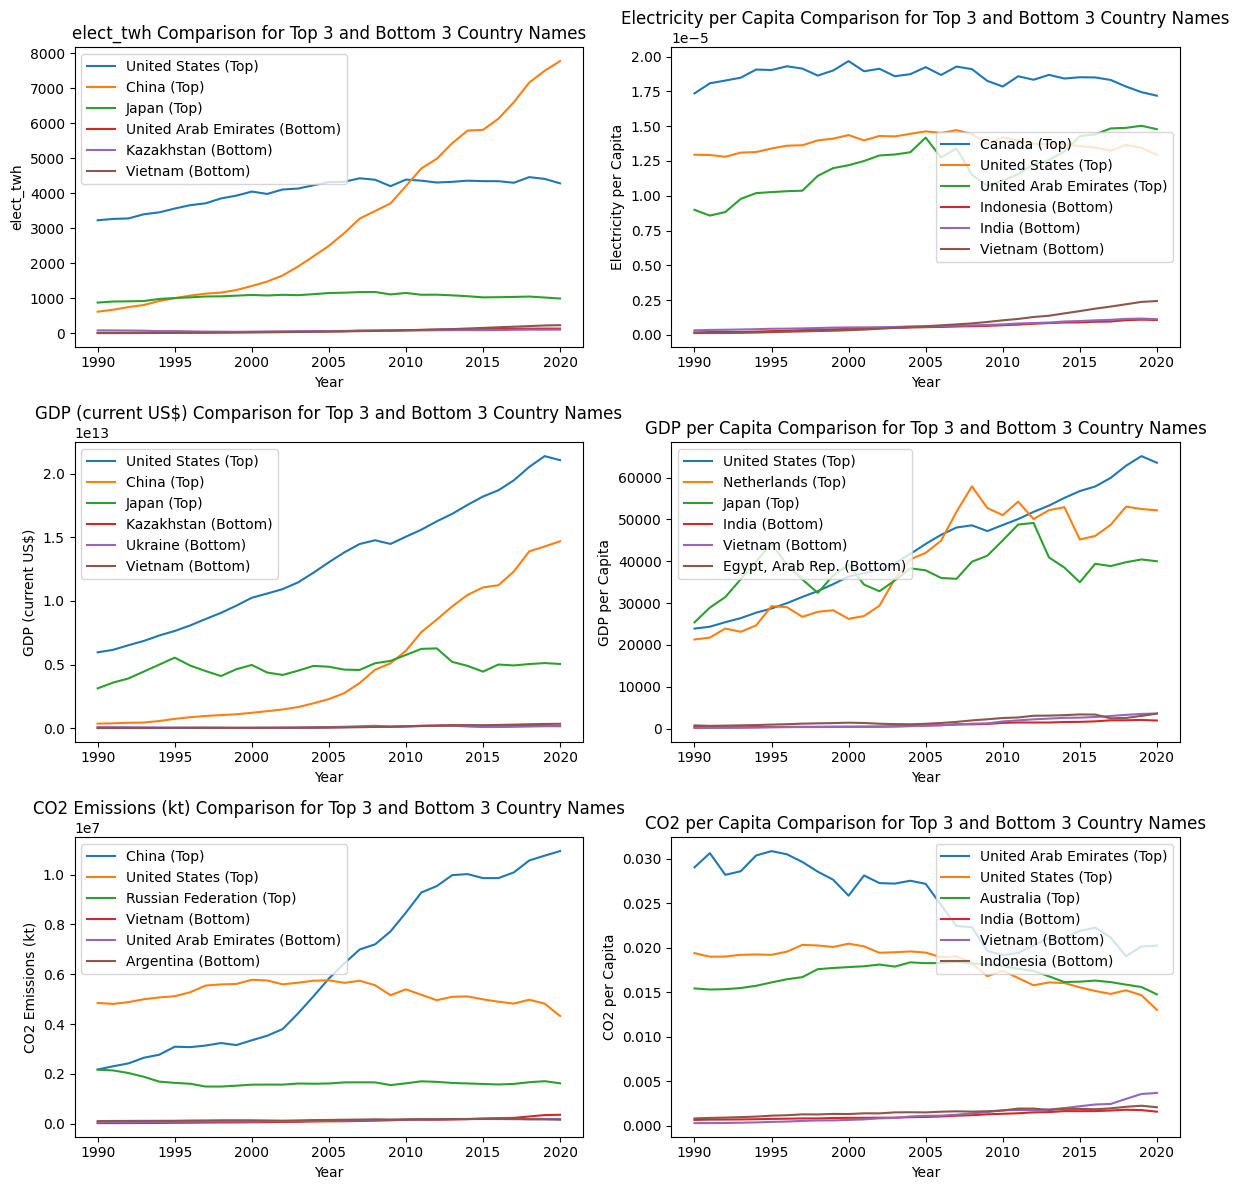

In [18]:
# Create line graphs for each metric
create_line_graph(
    plt,
    final_dataset,
    "Country Name",
    [
        "elect_twh",
        "Electricity per Capita",
        "GDP (current US$)",
        "GDP per Capita",
        "CO2 Emissions (kt)",
        "CO2 per Capita",
    ],
    top_n=3,
    bottom_n=3,
    fig_x=12,
    fig_y=12,
)

plt.tight_layout()
plt.show()

## 4. Summary
### 4.1 Conclusion
This exploratory data analysis attempted to identify the relationships between electricity production, GDP growth, and CO2 emissions. By carefully preparing the data, creating some exploratory visualisations, and attempting to interpret these, I've identified several interesting trends and exceptions that highlight the complex global landscape of energy and sustainability.

### 4.2 Key Takeaways
#### 4.2.1 Complex Correlations
The visualisations showcased a strong correlation between electricity production, GDP growth, and CO2 emissions in most cases, reflecting the interdependence of economic progress and energy demands.

#### 4.2.2 Country-Specific Dynamics
Exceptional cases like UAE, The Netherlands, Germany, South Africa, and others unveiled unique trajectories that highlighted the impact of energy challenges, policy choices, and historical shifts on these metrics.

#### 4.2.3 Renewable Resilience
The rise of renewable energy sources, such as solar, wind, and hydroelectric, underscores a global commitment towards sustainable energy generation. From the available data, it still seems that the greatest reduction in CO2 emissions are coming from gas, while other renewable sources still lag behind in larger production quantities.

#### 4.2.4 Fossil Fuel Complexities
The historic reliance on fossil fuels, especially for countries with large reserves, such as Russia, South Africa and the UAE grapple with the task of balancing economic prosperity with emissions reduction in a rapidly changing energy landscape.

## 5. References:

1. World Bank DataBank. Available at: [http://databank.worldbank.org/data/home.aspx](https://databank.worldbank.org/data/home.aspx)
1. Energy Institute Dataset. Source: [https://www.energyinst.org/statistical-review/resources-and-data-downloads](https://www.energyinst.org/statistical-review/resources-and-data-downloads)
1. Wes McKinney, Python for Data Analysis, 2nd Edition, O'Reilly Media, Inc, ISBN: 9781491957660
1. Python, [https://docs.python.org/3/](https://docs.python.org/3/)

## 6. In Closing
I am grateful for the opportunity to explore this interesting data landscape and am keen to continue investigating these findings further.